<a href="https://colab.research.google.com/github/rishabh-bhardwaj-64rr/EVA5/blob/master/S4/Session_4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # receptive field = 3
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # rf = 5
            nn.BatchNorm2d(32),
            nn.Dropout(0.10),
            nn.ReLU()
        )

        # transition block 1
        self.conv_1_1 = nn.Sequential(
            nn.MaxPool2d(2, 2), # rf = 10
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1), 
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU()
        )
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), # rf = 12
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), # rf = 14
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU()
        )

        # transition block 2
        self.conv_1_2 = nn.Sequential(
            nn.MaxPool2d(2, 2), # rf = 28
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1), 
            nn.BatchNorm2d(8),
            nn.Dropout(0.10),
            nn.ReLU()
        )
        # end

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3), # rf = 30
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # rf = 32
            nn.ReLU()
        )

        # final layer
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=3), # rf = 34
        )
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv_1_2(x)
            x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)

            x = x.view(-1, 10)
            return F.log_softmax(x)


## Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
           Dropout-3           [-1, 16, 28, 28]               0
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
           Dropout-7           [-1, 32, 28, 28]               0
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]             528
      BatchNorm2d-11           [-1, 16, 14, 14]              32
          Dropout-12           [-1, 16, 14, 14]               0
             ReLU-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

## Data loading and transformations

In [ ]:
torch.manual_seed(1) # for consistent output
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # mean, std of the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


## Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # setting the gradients to zero after every backprop step
    y_pred = model(data) # predicting the values
    loss = F.nll_loss(y_pred, target) # calculating the loss using negative loss likelihood
    train_losses.append(loss)
    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.append(100. * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print('Epoch:',  epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.011405476368963718 Batch_id=937 Accuracy=92.56: 100%|██████████| 938/938 [00:31<00:00, 29.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9684/10000 (96.84%)

Epoch: 2


Loss=0.01796569675207138 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:32<00:00, 28.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9862/10000 (98.62%)

Epoch: 3


Loss=0.07513894140720367 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:32<00:00, 29.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9866/10000 (98.66%)

Epoch: 4


Loss=0.07031643390655518 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:32<00:00, 28.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9838/10000 (98.38%)

Epoch: 5


Loss=0.015664847567677498 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:32<00:00, 28.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

Epoch: 6


Loss=0.13672569394111633 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:32<00:00, 28.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

Epoch: 7


Loss=0.07449933886528015 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

Epoch: 8


Loss=0.005990088451653719 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:32<00:00, 28.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

Epoch: 9


Loss=0.03348889574408531 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:32<00:00, 29.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9923/10000 (99.23%)

Epoch: 10


Loss=0.004718997050076723 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:32<00:00, 29.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9915/10000 (99.15%)

Epoch: 11


Loss=0.0038732991088181734 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:31<00:00, 29.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9918/10000 (99.18%)

Epoch: 12


Loss=0.09020570665597916 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

Epoch: 13


Loss=0.03594782575964928 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:32<00:00, 28.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

Epoch: 14


Loss=0.03013654239475727 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

Epoch: 15


Loss=0.02149870991706848 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:32<00:00, 29.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

Epoch: 16


Loss=0.0025972253642976284 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:31<00:00, 29.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

Epoch: 17


Loss=0.1456896960735321 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:32<00:00, 29.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)

Epoch: 18


Loss=0.002306105801835656 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:31<00:00, 29.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

Epoch: 19


Loss=0.2770474851131439 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]



Test set: Average loss: 0.0180, Accuracy: 9936/10000 (99.36%)



 # **BEST TEST ACCURACY = 99.42% IN 13TH EPOCH**

 # **BEST TRAIN ACCURACY = 99.21%**

 ## **NUMBER OF PARAMETERS = 19,042**

## Plotting

Text(0.5, 1.0, 'Test Accuracy')

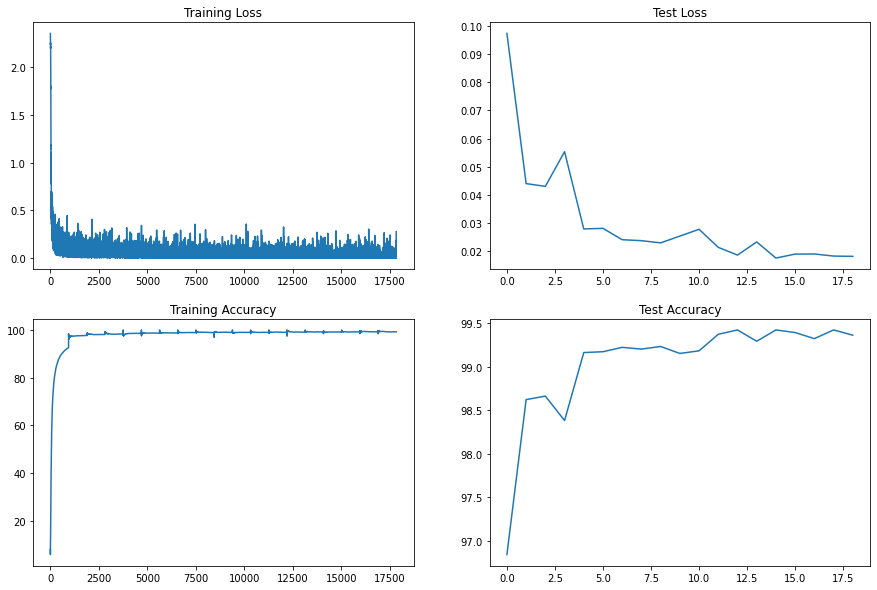

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")